# カギ足の描画

出典1：plot a kagi chart using python not JavaScript or other code

https://stackoverfLow.com/questions/75027757/plot-a-kagi-chart-using-python-not-javascript-or-other-code

出典2：Matplotlib 時系列データの軸設定｜自由に時間軸を設定！

https://www.yutaka-note.com/entry/matplotlib_time_axis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.dates as mdates

## 株価データの取得

In [2]:
# Define the stock symbol and timeframe
symbol = '9006.T'
end_date = datetime.today()
start_date = end_date - timedelta(days=180)  # 6 months before today
yf.pdr_override()
# yahooサイトからデータをダウンロード
stock_data = pdr.get_data_yahoo(symbol, start_date, end_date)
stock_data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-30,1268.0,1268.5,1250.5,1262.0,1262.0,1263800
2023-12-01,1268.0,1270.0,1259.5,1259.5,1259.5,757900
2023-12-04,1258.0,1262.0,1250.5,1255.5,1255.5,673400
2023-12-05,1251.5,1270.0,1249.5,1263.0,1263.0,828000
2023-12-06,1260.0,1271.5,1259.0,1270.0,1270.0,172100


## カギ足のためのデータ準備の関数

In [3]:
def KagiChart(df,delta):
    # カギ足描画のためのデータフレームの初期化
    kagi_df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Direc'])

    # データの出発点における設定
    trend = 0
    kagi = df.iloc[0]['Close']
    kagi_df.loc[0] = [df.iloc[0]['Date'], df.iloc[0]['Open'], df.iloc[0]['High'], df.iloc[0]['Low'], df.iloc[0]['Close'], df.iloc[0]['Volume'], 'Line']

    # 2行目以降のデータの扱い
    k = 1
    for i in range(1, df.shape[0]):
        # 下降トレンド中で価格変化が上昇反転ルールを満たした場合
        if trend <= 0 and df.iloc[i]['Close'] > kagi+delta:
            kagi_df.loc[k] = [df.iloc[i]['Date'], df.iloc[i]['Open'], df.iloc[i]['High'], df.iloc[i]['Low'], df.iloc[i]['Close'], df.iloc[i]['Volume'], 'up']
            kagi = df.iloc[i]['Close']
            trend = 1
            k += 1
        # 上昇トレンド中で価格変化が下降反転ルールを満たした場合
        elif trend >= 0 and df.iloc[i]['Close'] < kagi-delta:
            kagi_df.loc[k] = [df.iloc[i]['Date'], df.iloc[i]['Open'], df.iloc[i]['High'], df.iloc[i]['Low'], df.iloc[i]['Close'], df.iloc[i]['Volume'], 'down']
            kagi = df.iloc[i]['Close']
            trend = -1
            k += 1
        # 下降トレンド中で引き続き下降を示した場合
        elif trend <= 0 and df.iloc[i]['Close'] <= kagi:
            kagi = df.iloc[i]['Close']
            trend = -1
        # 上昇トレンド中で引き続き上昇を示した場合
        elif trend >= 0 and df.iloc[i]['Close'] >= kagi:
            kagi = df.iloc[i]['Close']
            trend = 1
        # 上記以外の場合は何もしない
    return kagi_df

## カギ足チャートの描画

        Date    Open    High     Low   Close   Volume Direc
0 2023-06-09  1325.0  1330.0  1315.0  1326.5   783700  Line
1 2023-06-19  1282.0  1295.0  1275.0  1288.0   888000    up
2 2023-06-26  1296.0  1297.0  1276.0  1287.0   637600  down
3 2023-06-28  1283.5  1299.5  1282.5  1299.0   481500    up
4 2023-06-29  1298.0  1301.5  1276.5  1278.0   759600  down
5 2023-07-03  1276.0  1303.0  1276.0  1302.0  1149400    up
6 2023-07-05  1293.5  1296.0  1285.5  1290.5   543000  down
7 2023-07-10  1292.0  1303.0  1286.0  1297.0   746900    up
8 2023-07-18  1291.0  1295.5  1286.0  1290.5   498200  down
9 2023-07-19  1299.0  1307.0  1293.0  1307.0   499900    up


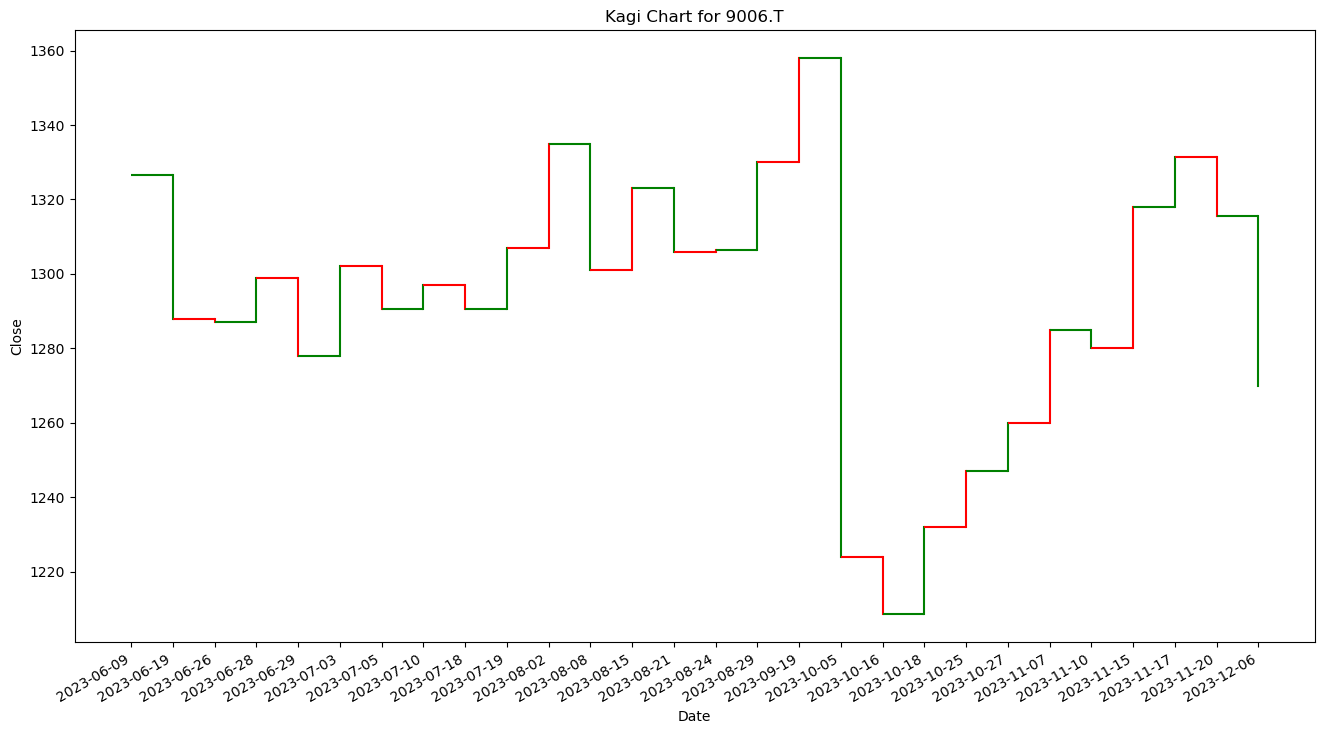

In [4]:
# 株価データの準備
df = stock_data.copy().reset_index()
delta = 10 # 反転基準価格差の設定
df_kagi = KagiChart(df,delta)
print(df_kagi.head(10))
Date = df_kagi['Date']
Close = df_kagi['Close']
direction = df_kagi['Direc']
# X軸変数として用いるインデックスの生成
indices = range(len(Date))
fig, ax = plt.subplots(figsize =(16,9))
# 軸目盛には日付を対応させる
plt.xticks(indices, [date.strftime('%Y-%m-%d') for date in Date])
fig.autofmt_xdate()
# 上又は下方向の垂直線を描画し、同じくその起点から左方向へ水平線を描画する
for i in range(1,len(Date)):
    if direction[i] == 'Line':
        ax.plot([indices[i], indices[i]], [Close[i-1], Close[i]], color='b')
    if direction[i] == 'up':
        ax.plot([indices[i], indices[i]], [Close[i-1], Close[i]], color='g')
        plt.hlines(Close[i-1], xmin=indices[i-1], xmax=indices[i],color='g')
    else:
        ax.plot([indices[i], indices[i]], [Close[i-1], Close[i]], color='r')
        plt.hlines(Close[i-1], xmin=indices[i-1], xmax=indices[i],color='r')
# グラフタイトルと軸ラベルを設定する
ax.set_title('Kagi Chart for '+symbol)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.show()